In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
import os
%matplotlib qt

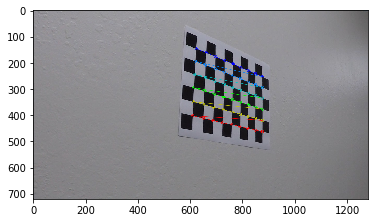

In [2]:
#List of calibration images
images=glob.glob('./camera_cal/calibration*.jpg')

#Arrays to store object points and image points
objPoints=[] # 3D points in real world space
imagePoints=[] # 2D points in image plane

# prepare object points
objp=np.zeros((9*6,3), np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2) #gives x,y values
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y
gray=[]
for file in images:
    # Read Image 
    img = mpimg.imread(file)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        imagePoints.append(corners)
        objPoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imagePoints, gray.shape[::-1], None, None)


In [3]:
#1
src = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])

#2
# src = np.float32([[200,720], [555, 475], [725,475], [1100,720]])
# dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])

#3
# src = np.float32([[544,477],[743,477],[1048,651],[260,651]])
# dst = np.float32([[200,50],[1079,50],[1079,680],[200,680]])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst,src)

# Returns the undistorted image
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img = cv2.undistort(img,mtx, dist,None,mtx)
    return img

def perspective_transform(image,matrix=M):
    warped = cv2.warpPerspective(image, matrix, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped


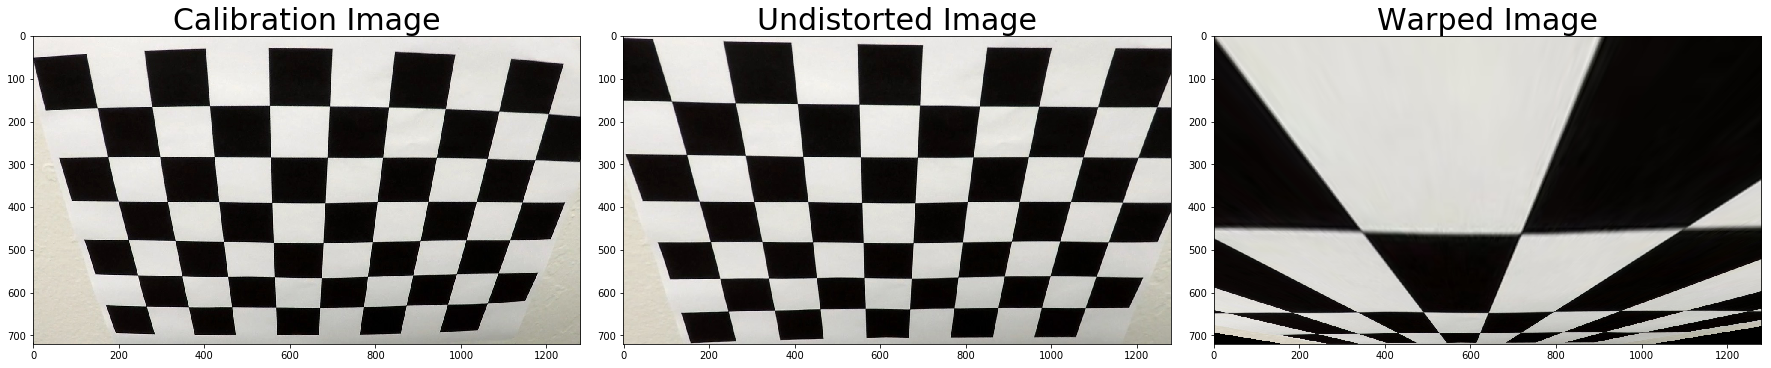

In [13]:
testImage1=mpimg.imread('./camera_cal/calibration2.jpg')
undistorted = cal_undistort(testImage1)
warped=perspective_transform(undistorted)
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImage1)
ax1.set_title("Calibration Image",fontsize=30)
ax2.imshow(undistorted)
ax2.set_title("Undistorted Image",fontsize=30)
ax3.imshow(warped)
ax3.set_title("Warped Image",fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
#Sliding Window

def sliding_window(binary_warped,left_fit_in,right_fit_in):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    coefficients_list=[]
    if len(coefficients_list)==0:
        left_fit=[]
        right_fit=[]
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        coefficients_list.append([left_fit,right_fit])
        
        
        return left_fit,right_fit

    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit_in[0]*(nonzeroy**2) + left_fit_in[1]*nonzeroy + 
        left_fit_in[2] - margin)) & (nonzerox < (left_fit_in[0]*(nonzeroy**2) + 
        left_fit_in[1]*nonzeroy + left_fit_in[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit_in[0]*(nonzeroy**2) + right_fit_in[1]*nonzeroy + 
        right_fit_in[2] - margin)) & (nonzerox < (right_fit_in[0]*(nonzeroy**2) + 
        right_fit_in[1]*nonzeroy + right_fit_in[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        return left_fit,right_fit


In [6]:
# Combining thresholds

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 150)):
    # 1) Convert to grayscale
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel=cv2.Sobel(img,cv2.CV_64F,1,0)

    elif orient=='y':
        sobel=cv2.Sobel(img,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel=np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
   
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(img,cv2.CV_64F,1,0,sobel_kernel)
    sobely=cv2.Sobel(img,cv2.CV_64F,0,1,sobel_kernel)
    
    # 3) Calculate the magnitude
  
    abs_sobelxy=np.sqrt(np.square(sobelx)+np.square(sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met

    sxybinary = np.zeros_like(scaled_sobelxy)
    sxybinary[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return sxybinary

def dir_threshold(img, sobel_kernel=3, thresh=[90,255]):
    # 1) Convert to grayscale
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(img,cv2.CV_64F,1,0,sobel_kernel)
    sobely=cv2.Sobel(img,cv2.CV_64F,0,1,sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgrad=np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    absgradbinary=np.zeros_like(absgrad)
    # 6) Return this mask as your binary_output image
    absgradbinary[(absgrad >= thresh[0]) & (absgrad <= thresh[1])] = 1
    return absgradbinary


def color_threshold(image):
    hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    l_channel=hls[:,:,1]
    thresh = (80, 255)
    thresh1 = (100, 255)
    s_binary = np.zeros_like(s_channel)
    l_binary = np.zeros_like(l_channel)
    s_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    l_binary[(l_channel > thresh1[0]) & (l_channel <= thresh1[1])] = 1
    binary= np.zeros_like(s_channel)
    binary[(s_binary==1) & (l_binary==1)] =1
    return binary

def radious_of_curvature(fitx, length):
    ploty = np.linspace(0, length-1, length )
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    return ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])



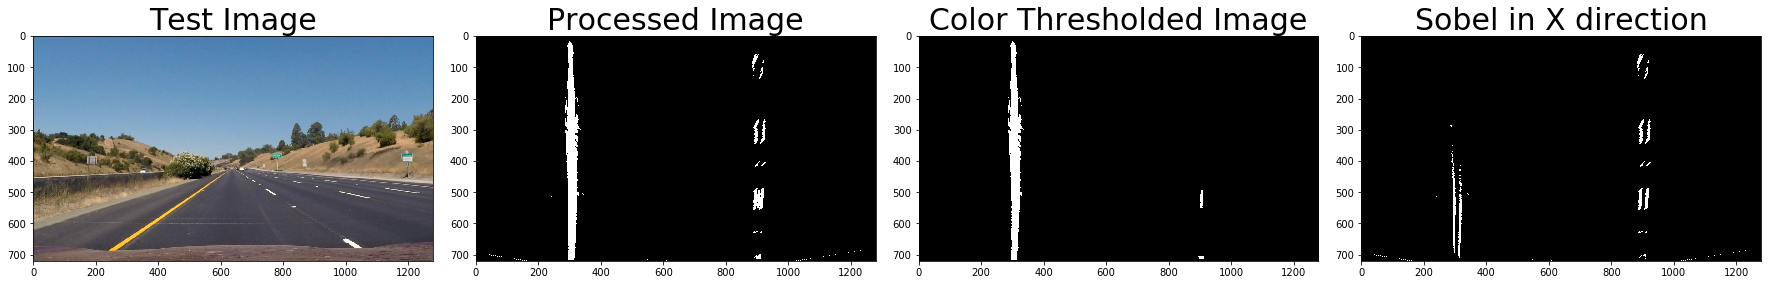

In [7]:
testImage=mpimg.imread('./test_images/straight_lines1.jpg')
undistort=cal_undistort(testImage)
warp=perspective_transform(undistort)
color_thresh=color_threshold(warp)
sxbinary=abs_sobel_thresh(warp, orient='x', sobel_kernel=17, thresh=(30, 100))
combined = np.zeros_like(sxbinary)
combined[((sxbinary == 1) | (color_thresh==1))] = 1
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImage)
ax1.set_title("Test Image", fontsize=30)
ax2.imshow(combined,cmap='gray')
ax2.set_title("Processed Image", fontsize=30)
ax3.imshow(color_thresh,cmap='gray')
ax3.set_title("Color Thresholded Image", fontsize=30)
ax4.imshow(sxbinary,cmap='gray')
ax4.set_title("Sobel in X direction", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [24]:
import os
class VideoProcessor(object):
#     count=1
    left_fit = []
    right_fit = []
    
    prev_ten_left_fit = []
    prev_ten_right_fit = []
    
    mean_left_fit=[]
    mean_right_fit=[]
    
    def pipeline(self,image):
#         path = './images'
#         image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#         cv2.imwrite(os.path.join(path , 'waka'+str(self.count)+'.jpg'), image)
#         self.count+=1
        undistort=cal_undistort(image)
        warp=perspective_transform(undistort)
        color_thresh=color_threshold(warp)
        sxbinary=abs_sobel_thresh(warp, orient='x', sobel_kernel=17, thresh=(30, 100))
        dir_binary = dir_threshold(warp, sobel_kernel=17, thresh=(0.7, 1.3))
        combined = np.zeros_like(sxbinary)
        combined[(((sxbinary == 1) & (dir_binary==1)) | (color_thresh==1))] = 1
        combined=cal_undistort(combined)
        self.left_fit, self.right_fit = sliding_window(combined,self.mean_left_fit,self.mean_right_fit)
        
        if(len(self.prev_ten_left_fit)>10):
            self.prev_ten_left_fit = self.prev_ten_left_fit[1:]
            self.prev_ten_right_fit = self.prev_ten_right_fit[1:]
        self.prev_ten_left_fit.append(self.left_fit)
        self.prev_ten_right_fit.append(self.right_fit)
        
        self.mean_left_fit = np.mean(self.prev_ten_left_fit, axis=0)
        self.mean_right_fit = np.mean(self.prev_ten_right_fit, axis=0)
        
        ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
        left_fitx = self.mean_left_fit[0]*ploty**2 + self.mean_left_fit[1]*ploty + self.mean_left_fit[2]
        right_fitx = self.mean_right_fit[0]*ploty**2 + self.mean_right_fit[1]*ploty + self.mean_right_fit[2]
    
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        output_image = np.zeros_like(undistorted)
        cv2.fillPoly(output_image, np.array([pts], dtype=np.int32), (0,255,0))
        
        output_image=perspective_transform(output_image,M_inv)
        img = cv2.addWeighted(image, 1, output_image, 0.3, 0)
        left_curverad = radious_of_curvature(left_fitx, combined.shape[0])
        right_curverad = radious_of_curvature(right_fitx, combined.shape[0])
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,'Radius Of Curvature = {0:.2f}(m)'.format(np.mean([left_curverad,right_curverad])),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        # compute the offset from the center
        lane_center = (right_fitx[combined.shape[0]-1] + left_fitx[combined.shape[0]-1])/2
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        center_offset_pixels = combined.shape[1]/2 - lane_center
        center_offset_mtrs = xm_per_pix*center_offset_pixels
        if center_offset_mtrs>=0:
            towards = 'left'
        else:
            towards = 'right'
        cv2.putText(img,'Vehicle is {0:.2f}m '.format(abs(center_offset_mtrs))+towards+' of center',(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)

        return img.astype(np.uint8)

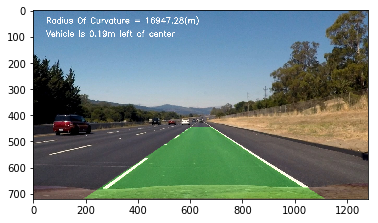

In [25]:
video_processor = VideoProcessor()
testImage=mpimg.imread('./test_images/straight_lines2.jpg')
combined=video_processor.pipeline(testImage)
plt.imshow(combined)

In [11]:
# Process Videos

video_processor = VideoProcessor()

white_output = './test_output_videos/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(video_processor.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_output_videos/project_video.mp4
[MoviePy] Writing video ./test_output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:52<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_output_videos/project_video.mp4 

Wall time: 15min 56s
